# mount google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls drive

MyDrive


In [3]:
cd /content/drive/MyDrive/Colab Notebooks/recommendation_systems

/content/drive/MyDrive/Colab Notebooks/recommendation_systems


In [4]:
! ls

 knowledge_distillation
 mind_dataset
 mind_news_data_process.ipynb
'mind_news_knowledge_distillation _category.ipynb'
 mind_news_knowledge_distillation_ctr.ipynb
 README.md
 restricted_boltzmann_machines_movie_recommendation.ipynb
 wip_jupyter_notebooks


# Install transformer

https://huggingface.co/transformers/installation.html

In [5]:
! pip install transformers
# ! pip install sentencepiece

     |████████████████████████████████| 2.5MB 25.8MB/s 
     |████████████████████████████████| 3.3MB 40.5MB/s 
     |████████████████████████████████| 901kB 51.9MB/s 


# Import modules

In [6]:
import os
import re
import time
import random
from glob import glob
import zipfile
import pickle
from pprint import pprint

import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px
from sklearn import metrics
from sklearn.metrics import classification_report, plot_confusion_matrix, confusion_matrix
from wordcloud import WordCloud

import torch
from torch import nn
import torch.nn.functional as F
import torchtext
from transformers import AutoModel, AutoTokenizer
import torch.optim as optim

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('max_colwidth', None)

%load_ext autoreload
%autoreload 2

In [7]:
# train and validate (instead of test) datasets are used here.
data_path_train = "/content/drive/MyDrive/Colab Notebooks/recommendation_systems/mind_dataset/MINDlarge_train/"
data_path_test = "/content/drive/MyDrive/Colab Notebooks/recommendation_systems/mind_dataset/MINDlarge_dev/"
filename_train = data_path_train + "news_click_df.csv"
filename_test = data_path_test + "news_click_df.csv"
select_text_flag = "title"
select_label_flag = "click_prob_flag" # category_flag # click_prob_flag
model_path = "/content/drive/MyDrive/Colab Notebooks/recommendation_systems/knowledge_distillation/trained_models/"

## set up environment

In [8]:
cd /content/drive/MyDrive/Colab Notebooks/recommendation_systems

/content/drive/MyDrive/Colab Notebooks/recommendation_systems


In [9]:
ls knowledge_distillation/

data_process.py      model_evaluation.py  __pycache__/
__init__.py          model_kd.py          set_up_environment.py
model_distilbert.py  model_lstm.py        trained_models/
model_doc2vec.py     model_word2vec.py


In [10]:
from knowledge_distillation.set_up_environment import set_random_seed, set_up_gpu

In [11]:
set_random_seed(999)
# device = set_up_gpu()
# print(device)

In [12]:
# Clear memory
# with torch.cuda.device('cuda:0'):
#     torch.cuda.empty_cache()

# Set up GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")      

In [13]:
import torch
torch.backends.cudnn.enabled=False

# process data

In [14]:
from knowledge_distillation.data_process import DataProcessing

In [15]:
dp = DataProcessing()
data_df_train = dp.get_data(data_path_train, select_text_flag, select_label_flag)
data_df_test = dp.get_data(data_path_test, select_text_flag, select_label_flag)

0    32812
1       23
Name: click_prob_flag, dtype: int64
1    32020
0      815
Name: category_flag, dtype: int64


,Unnamed: 0,id,category,subcategory,title,abstract,url,title_entities,abstract_entities,click,non_click,click_prob,click_prob_flag,category_flag,text,label
0,8,N124534,sports,football_nfl,Should NFL be able to fine players for criticizing officiating?,Several fines came down against NFL players for criticizing officiating this week. It's a very bad look for the league.,https://assets.msn.com/labs/mind/AAJ4lap.html,"[{""Label"": ""National Football League"", ""Type"": ""O"", ""WikidataId"": ""Q1215884"", ""Confidence"": 1.0, ""OccurrenceOffsets"": [7], ""SurfaceForms"": [""NFL""]}]","[{""Label"": ""National Football League"", ""Type"": ""O"", ""WikidataId"": ""Q1215884"", ""Confidence"": 1.0, ""OccurrenceOffsets"": [32], ""SurfaceForms"": [""NFL""]}]",NaN,NaN,0.0,0,1,Should NFL be able to fine players for criticizing officiating?,0
1,18,N107267,sports,football_nfl,"As Eagles take their bye, a look at how the defense has improved lately | Early Birds","Good morning, Eagles fans. Is everybody OK? I know it's been a tough couple days for you all, first with the Eagles' rough 22-14 win over the Chicago Bears and then with the news that the team's most potent deep threat, DeSean Jackson, will likely be out for the season after reinjuring himself during the four snaps he played on Sunday. But hey, it's the bye week. So if you want to use this ...",https://assets.msn.com/labs/mind/AAJWD4e.html,"[{""Label"": ""Philadelphia Eagles"", ""Type"": ""O"", ""WikidataId"": ""Q219714"", ""Confidence"": 0.93, ""OccurrenceOffsets"": [3], ""SurfaceForms"": [""Eagles""]}]","[{""Label"": ""Philadelphia Eagles"", ""Type"": ""O"", ""WikidataId"": ""Q219714"", ""Confidence"": 0.93, ""OccurrenceOffsets"": [14, 109], ""SurfaceForms"": [""Eagles"", ""Eagles""]}, {""Label"": ""DeSean Jackson"", ""Type"": ""P"", ""WikidataId"": ""Q984336"", ""Confidence"": 1.0, ""OccurrenceOffsets"": [220], ""SurfaceForms"": [""DeSean Jackson""]}, {""Label"": ""Chicago Bears"", ""Type"": ""O"", ""WikidataId"": ""Q205033"", ""Confidence"": 1.0, ""OccurrenceOffsets"": [142], ""SurfaceForms"": [""Chicago Bears""]}]",NaN,NaN,0.0,0,1,"As Eagles take their bye, a look at how the defense has improved lately | Early Birds",0


0    22252
1        4
Name: click_prob_flag, dtype: int64
1    21579
0      677
Name: category_flag, dtype: int64


,Unnamed: 0,id,category,subcategory,title,abstract,url,title_entities,abstract_entities,click,non_click,click_prob,click_prob_flag,category_flag,text,label
0,7,N124534,sports,football_nfl,Should NFL be able to fine players for criticizing officiating?,Several fines came down against NFL players for criticizing officiating this week. It's a very bad look for the league.,https://assets.msn.com/labs/mind/AAJ4lap.html,"[{""Label"": ""National Football League"", ""Type"": ""O"", ""WikidataId"": ""Q1215884"", ""Confidence"": 1.0, ""OccurrenceOffsets"": [7], ""SurfaceForms"": [""NFL""]}]","[{""Label"": ""National Football League"", ""Type"": ""O"", ""WikidataId"": ""Q1215884"", ""Confidence"": 1.0, ""OccurrenceOffsets"": [32], ""SurfaceForms"": [""NFL""]}]",NaN,NaN,0.0,0,1,Should NFL be able to fine players for criticizing officiating?,0
1,18,N117551,sports,football_nfl,"Rye football wins 2019 rendition of The Game, clobbers Harrison","After going into halftime tied, the Garnets regrouped and made a resounding second-half statement in The Game.",https://assets.msn.com/labs/mind/AAIGv0N.html,[],[],NaN,NaN,0.0,0,1,"Rye football wins 2019 rendition of The Game, clobbers Harrison",0


In [16]:
select_col = ["text","label"]
num_classes = len(data_df_train["label"].unique())

select_data_df_train = dp.select_data(data_df_train, select_col, decrease_fold=1)
select_data_df_test = dp.select_data(data_df_test, select_col, decrease_fold=1)
select_data_df_train.head(2)

0    32812
1       23
Name: label, dtype: int64
0    22252
1        4
Name: label, dtype: int64


,text,label
0,Should NFL be able to fine players for criticizing officiating?,0
1,"As Eagles take their bye, a look at how the defense has improved lately | Early Birds",0


In [17]:
select_data_df_train, select_data_df_test = dp.clean_data(select_data_df_train, select_data_df_test)

dp.save_data_to_csv(select_data_df_train, data_path_train, select_columns=["text_clean","label"])
dp.save_data_to_csv(select_data_df_test, data_path_test, select_columns=["text_clean","label"])

filename_ /content/drive/MyDrive/Colab Notebooks/recommendation_systems/mind_dataset/MINDlarge_train/news_click_df.csv
0    32812
1       23
Name: label, dtype: int64
filename_ /content/drive/MyDrive/Colab Notebooks/recommendation_systems/mind_dataset/MINDlarge_dev/news_click_df.csv
0    22252
1        4
Name: label, dtype: int64


# generate models

In [18]:
from knowledge_distillation.model_doc2vec import Doc2vecModelling, Doc2vecModelPrediction
from knowledge_distillation.model_distilbert import DistilBERTModelling
from knowledge_distillation.model_word2vec import Word2vecModelling
from knowledge_distillation.model_lstm import LstmModelling
from knowledge_distillation.model_kd import KnowledgeDistillationModelling
from knowledge_distillation.model_evaluation import plot_confusion_matrix_heatmap

In [19]:
# set up parameters
num_epochs = 10
batch_size = 32 # 32

In [20]:
kd = KnowledgeDistillationModelling
dv = Doc2vecModelling
db = DistilBERTModelling
lm = LstmModelling
wv = Word2vecModelling

## Doc2vec Model

In [21]:
# # select data
# train_text, train_label, test_text, test_label = dv.select_data(select_data_df_train, select_data_df_test)
# # generate doc2vec model
# doc2vec_model = dv.generate_doc2vec_model(data_path_train, train_text, 100)
# # process train and test data
# train_x, train_y, test_x, test_y, train_loader, test_loader = dv.process_data(doc2vec_model, train_text, train_label, test_text, test_label)
# # classify data using simple neural network
# num_labels = len(set(train_y))
# vocab_size = train_x.shape[1]
# print(vocab_size, num_labels)
# nn_model, train_loader = dv.classfiy_model_neural_network(train_loader, num_labels, vocab_size, num_epochs)

# dvmp = Doc2vecModelPrediction
# dvmp.predict_texts_nn(nn_model, train_loader, "doc2vec train")
# dvmp.predict_texts_nn(nn_model, test_loader, "doc2vec test")

## DistilBERT Model

In [22]:
# tokenizer  = db.get_tokenizer("distilbert-base-uncased")
# distilbert_model = db.generate_model(num_classes)

# train_iter_db, test_iter_db = db.process_text(tokenizer, 
#                                               filename_train, filename_test, batch_size)

# distilbert_model, device = db.train_distilbert(distilbert_model, device, 
#                                                train_iter_db, num_classes, num_epochs)

# db.predict_distilbert(distilbert_model, device, train_iter_db, "train")
# db.predict_distilbert(distilbert_model, device, test_iter_db, "test")

# LSTM Model

In [23]:
# train_iter_lm, test_iter_lm = lm.process_text(filename_train, filename_test, batch_size)
# lstm_model = lm.generate_model(num_classes)
# lstm_model, device = lm.train(lstm_model, device, train_iter_lm, num_classes, num_epochs, token_flag="lstm")
# lm.predict(lstm_model, device, train_iter_lm, token_flag="lstm", title_name="train")
# lm.predict(lstm_model, device, test_iter_lm, token_flag="lstm", title_name="test")
# lstm_model

## Simple Embedding Model

In [24]:
# train_iter_mv, test_iter_mv = wv.process_text(filename_train, filename_test, batch_size)
# glove_model = wv.generate_model(num_classes)
# glove_model, device = wv.train_embedding(glove_model, device, train_iter_mv, num_classes, num_epochs)
# wv.predict_embedding(glove_model, device, train_iter_mv, title_name=None)
# wv.predict_embedding(glove_model, device, test_iter_mv, title_name=None)

# Knowledge Distillation

In [25]:
token_name = "distilbert"
tokenizer  = db.get_tokenizer("distilbert-base-uncased")
train_iter_kd, test_iter_kd = db.process_text(tokenizer, 
                                              filename_train, filename_test, batch_size)

# train_iter_kd, test_iter_kd = lm.process_text(filename_train, filename_test, batch_size)


Size of TEXT vocabulary: 462207
Size of LABEL vocabulary: 3


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


model_name:  distilbert
token_name:  distilbert
epoch:  0 	 loss:  11.361126956398948
epoch:  1 	 loss:  5.271147773659322
epoch:  2 	 loss:  4.166764530478758
epoch:  3 	 loss:  2.4043566318778176
epoch:  4 	 loss:  1.0909324754281897
epoch:  5 	 loss:  0.5539675808561242
epoch:  6 	 loss:  0.3431433115129039
epoch:  7 	 loss:  0.20295030519889679
epoch:  8 	 loss:  0.13345754794340792
epoch:  9 	 loss:  0.3333366303020284
time :  231.35043835639954
time :  17.144055128097534
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     32813
           1       0.96      1.00      0.98        22

    accuracy                           1.00     32835
   macro avg       0.98      1.00      0.99     32835
weighted avg       1.00      1.00      1.00     32835

predicted label:  {0, 1}
Accuracy: 0.9999695446931628
Precision: 0.9999695456213104
Recall: 0.9999695446931628
F1 Score: 0.999969206532905


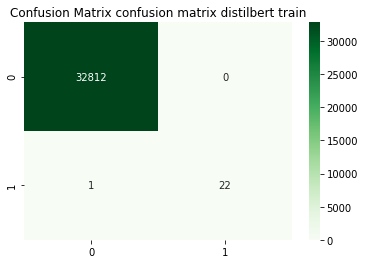

precision_score 0.956552194437272
roc_auc_score-auc: 0.9782608695652174
roc_curve-fpr: [0. 0. 1.]
roc_curve-tpr: [0.         0.95652174 1.        ]


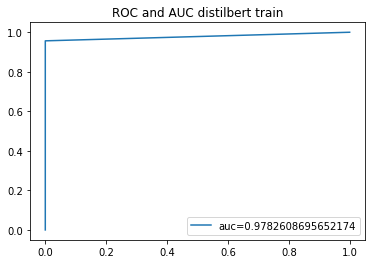

time :  11.675378322601318
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22245
           1       0.00      0.00      0.00        11

    accuracy                           1.00     22256
   macro avg       0.50      0.50      0.50     22256
weighted avg       1.00      1.00      1.00     22256

predicted label:  {0, 1}
Accuracy: 0.9993260244428469
Precision: 0.9996404898135414
Recall: 0.9993260244428469
F1 Score: 0.9994832323932952


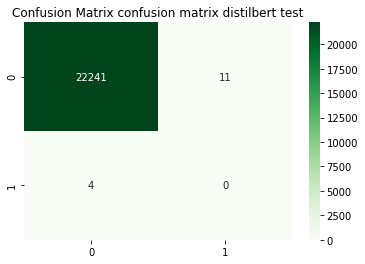

precision_score 0.00017972681524083394
roc_auc_score-auc: 0.4997528312061837
roc_curve-fpr: [0.00000000e+00 4.94337588e-04 1.00000000e+00]
roc_curve-tpr: [0. 0. 1.]


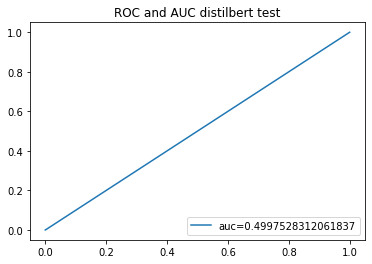

In [26]:
distilbert_model2 = db.generate_model(num_classes)
distilbert_model2, device = kd.train(distilbert_model2, device, 
                                    train_iter_kd, "distilbert", token_name, 
                                    num_classes, num_epochs, model_path)

kd.predict(distilbert_model2, device, train_iter_kd, token_name, "distilbert train")
kd.predict(distilbert_model2, device, test_iter_kd, token_name, "distilbert test")

LSTMModel(
  (embedding): Embedding(30000, 128)
  (lstm): LSTM(128, 16, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=2, bias=True)
)
model_name:  lstm
token_name:  distilbert
epoch:  0 	 loss:  19.377384641586104
epoch:  1 	 loss:  5.947290882235393
epoch:  2 	 loss:  5.341663691753638
epoch:  3 	 loss:  2.471794176410185
epoch:  4 	 loss:  0.8466091852224054
epoch:  5 	 loss:  0.2690072451441665
epoch:  6 	 loss:  0.1570102872701682
epoch:  7 	 loss:  0.1256385503168076
epoch:  8 	 loss:  0.10507425698017414
epoch:  9 	 loss:  0.11025811440424604
time :  95.31278157234192
time :  2.399332284927368
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     32811
           1       1.00      0.96      0.98        24

    accuracy                           1.00     32835
   macro avg       1.00      0.98      0.99     32835
weighted avg       1.00      1.00      1.00     32835

predicted label:  {0, 1}
Accuracy: 0

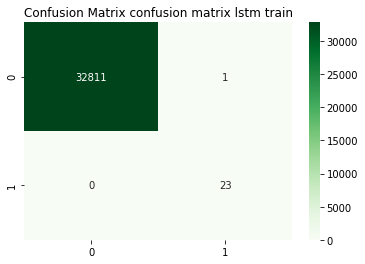

precision_score 0.9583333333333334
roc_auc_score-auc: 0.9999847616725589
roc_curve-fpr: [0.00000000e+00 3.04766549e-05 1.00000000e+00]
roc_curve-tpr: [0. 1. 1.]


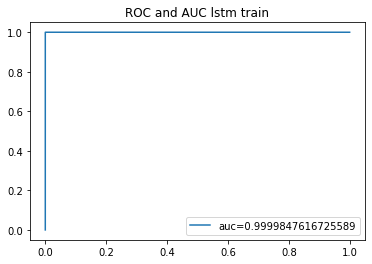

time :  1.5696516036987305
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22245
           1       0.00      0.00      0.00        11

    accuracy                           1.00     22256
   macro avg       0.50      0.50      0.50     22256
weighted avg       1.00      1.00      1.00     22256

predicted label:  {0, 1}
Accuracy: 0.9993260244428469
Precision: 0.9996404898135414
Recall: 0.9993260244428469
F1 Score: 0.9994832323932952


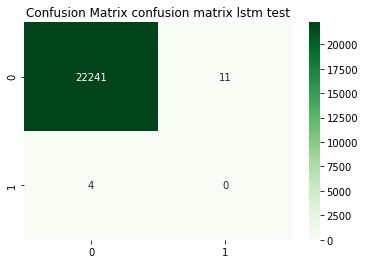

precision_score 0.00017972681524083394
roc_auc_score-auc: 0.4997528312061837
roc_curve-fpr: [0.00000000e+00 4.94337588e-04 1.00000000e+00]
roc_curve-tpr: [0. 0. 1.]


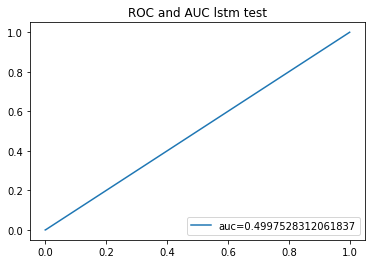

In [27]:
lstm_model2 = lm.generate_model(num_classes)
lstm_model2, device = kd.train(lstm_model2, device, train_iter_kd, 
                                  "lstm", token_name, num_classes, num_epochs, model_path)
kd.predict(lstm_model2, device, train_iter_kd, token_name, title_name="lstm train")
kd.predict(lstm_model2, device, test_iter_kd, token_name, title_name="lstm test")

2 30000
EmbeddingBagModel(
  (embedding): EmbeddingBag(30000, 128, mode=mean)
  (linear): Linear(in_features=128, out_features=2, bias=True)
)
model_name:  glove
token_name:  distilbert
epoch:  0 	 loss:  38.54739666516252
epoch:  1 	 loss:  5.990230652721948
epoch:  2 	 loss:  4.625776935059548
epoch:  3 	 loss:  3.309969521666062
epoch:  4 	 loss:  2.0088279489209526
epoch:  5 	 loss:  0.9578977567780385
epoch:  6 	 loss:  0.5051803740889227
epoch:  7 	 loss:  0.31025048080277884
epoch:  8 	 loss:  0.19042938008695387
epoch:  9 	 loss:  0.1516717108271166
time :  34.100414991378784
time :  1.1185972690582275
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     32811
           1       1.00      0.96      0.98        24

    accuracy                           1.00     32835
   macro avg       1.00      0.98      0.99     32835
weighted avg       1.00      1.00      1.00     32835

predicted label:  {0, 1}
Accuracy: 0.9999695446931628
P

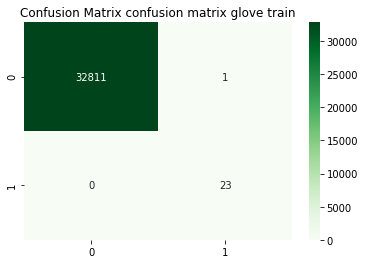

precision_score 0.9583333333333334
roc_auc_score-auc: 0.9999847616725589
roc_curve-fpr: [0.00000000e+00 3.04766549e-05 1.00000000e+00]
roc_curve-tpr: [0. 1. 1.]


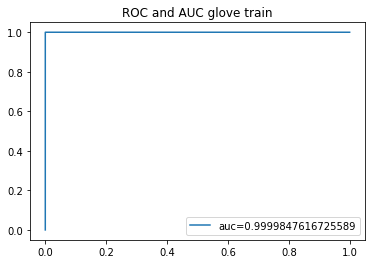

time :  0.7053334712982178
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22246
           1       0.00      0.00      0.00        10

    accuracy                           1.00     22256
   macro avg       0.50      0.50      0.50     22256
weighted avg       1.00      1.00      1.00     22256

predicted label:  {0, 1}
Accuracy: 0.999370956146657
Precision: 0.9996404978951459
Recall: 0.999370956146657
F1 Score: 0.9995057088487308


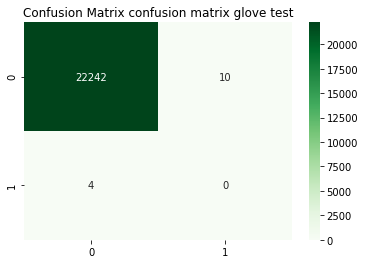

precision_score 0.00017972681524083394
roc_auc_score-auc: 0.4997753010965306
roc_curve-fpr: [0.00000000e+00 4.49397807e-04 1.00000000e+00]
roc_curve-tpr: [0. 0. 1.]


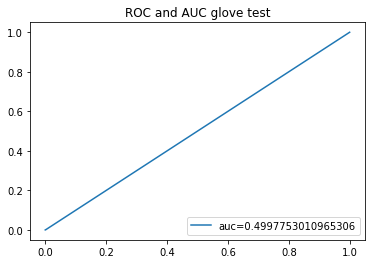

In [28]:
glove_model2 = wv.generate_model(num_classes)

glove_model2, device = kd.train(glove_model2, device, train_iter_kd, 
                                "glove", token_name, num_classes, num_epochs, model_path)
kd.predict(glove_model2, device, train_iter_kd, token_name, title_name="glove train")
kd.predict(glove_model2, device, test_iter_kd, token_name, title_name="glove test")

In [29]:
# student models
student_model = glove_model2

# teacher models
teachers = [lstm_model2, distilbert_model2]
teachers_name = ["lstm", "distilbert"]

# teachers = [distilbert_model, lstm_model, glove_model]
teacher_models = []
for idx, te_model in enumerate(teachers):
    # print(te_model)
    te_model.load_state_dict(torch.load(model_path + teachers_name[idx] + '.pth'))
    te_model#.to(device)
    # te_model.eval()  # eval mode
    teacher_models.append(te_model)
teacher_models

[LSTMModel(
   (embedding): Embedding(30000, 128)
   (lstm): LSTM(128, 16, num_layers=2, batch_first=True)
   (fc): Linear(in_features=32, out_features=2, bias=True)
 ), DistilBERTClassifierNetwork(
   (distil_bert): DistilBertModel(
     (embeddings): Embeddings(
       (word_embeddings): Embedding(30522, 768, padding_idx=0)
       (position_embeddings): Embedding(512, 768)
       (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
       (dropout): Dropout(p=0.1, inplace=False)
     )
     (transformer): Transformer(
       (layer): ModuleList(
         (0): TransformerBlock(
           (attention): MultiHeadSelfAttention(
             (dropout): Dropout(p=0.1, inplace=False)
             (q_lin): Linear(in_features=768, out_features=768, bias=True)
             (k_lin): Linear(in_features=768, out_features=768, bias=True)
             (v_lin): Linear(in_features=768, out_features=768, bias=True)
             (out_lin): Linear(in_features=768, out_features=768, bias=Tr

epoch:  0 	 loss:  226.82106721401215
epoch:  1 	 loss:  76.259605480358
epoch:  2 	 loss:  50.861682150512934
epoch:  3 	 loss:  41.1305534732528
epoch:  4 	 loss:  36.69594701891765
epoch:  5 	 loss:  34.45958683406934
epoch:  6 	 loss:  32.8629285232164
epoch:  7 	 loss:  32.10504488507286
epoch:  8 	 loss:  31.489557241322473
epoch:  9 	 loss:  31.037345219403505
time :  196.8348572254181
time :  1.148385763168335
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     32835
           1       0.00      0.00      0.00         0

    accuracy                           1.00     32835
   macro avg       0.50      0.50      0.50     32835
weighted avg       1.00      1.00      1.00     32835

predicted label:  {0}
Accuracy: 0.999299527942744
Precision: 0.998599546546591
Recall: 0.999299527942744
F1 Score: 0.9989494146223687


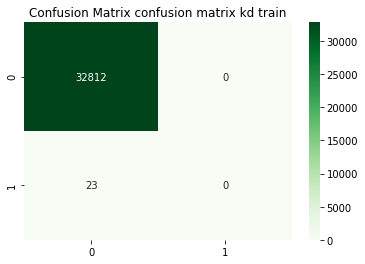

precision_score 0.0007004720572559768
roc_auc_score-auc: 0.5
roc_curve-fpr: [0. 1.]
roc_curve-tpr: [0. 1.]


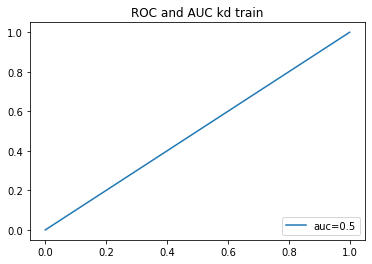

time :  0.739325761795044
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22256
           1       0.00      0.00      0.00         0

    accuracy                           1.00     22256
   macro avg       0.50      0.50      0.50     22256
weighted avg       1.00      1.00      1.00     22256

predicted label:  {0}
Accuracy: 0.9998202731847592
Precision: 0.9996405786712464
Recall: 0.9998202731847592
F1 Score: 0.9997304178532965


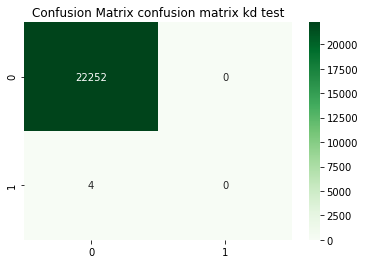

precision_score 0.00017972681524083394
roc_auc_score-auc: 0.5
roc_curve-fpr: [0. 1.]
roc_curve-tpr: [0. 1.]


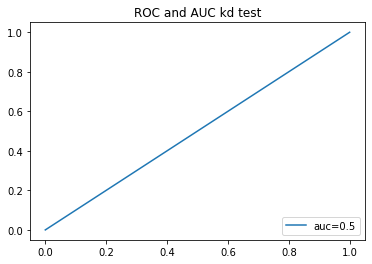

In [30]:
trained_student_model, device = kd.train_multi_teachers_kd(student_model, teacher_models, 
                                                device, 
                                                train_iter_kd, num_epochs)
kd.predict(trained_student_model, device, train_iter_kd, token_name="distilbert", title_name="kd train")
kd.predict(trained_student_model, device, test_iter_kd, token_name="distilbert", title_name="kd test")

# Unmount and flush google drive

In [32]:
from google.colab import drive
drive.flush_and_unmount()